In [28]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assumes best_rf and scaler exist in the environment (from training)

# Widgets for numeric features
nitrogen = widgets.FloatSlider(min=-3, max=3, step=0.1, description='Nitrogen:')
phosphorus = widgets.FloatSlider(min=-3, max=3, step=0.1, description='Phosphorus:')
potassium = widgets.FloatSlider(min=-3, max=3, step=0.1, description='Potassium:')
rainfall = widgets.FloatSlider(min=-3, max=3, step=0.1, description='Rainfall:')
temperature = widgets.FloatSlider(min=-3, max=3, step=0.1, description='Temperature:')
ph_value = widgets.FloatSlider(min=-3, max=3, step=0.1, description='pH:')

# Dropdowns for categorical features
crop = widgets.Dropdown(options=[0,1,2], description='Crop:')
district_name = widgets.Dropdown(options=[0,1,2], description='District:')
soil_color = widgets.Dropdown(options=[0,1,2], description='Soil Color:')

predict_button = widgets.Button(description='Predict Fertilizer')
output = widgets.Output()

def on_predict_clicked(b):
    with output:
        output.clear_output()
        # Prepare input dict with all features
        input_data = {
            'Nitrogen': [nitrogen.value],
            'Phosphorus': [phosphorus.value],
            'Potassium': [potassium.value],
            'Rainfall': [rainfall.value],
            'Temperature': [temperature.value],
            'pH': [ph_value.value],
            'Crop': [crop.value],
            'District_Name': [district_name.value],
            'Soil_color': [soil_color.value]
        }
        input_df = pd.DataFrame(input_data)

        # Use scaler's recorded feature names in expected order
        scaler_cols = list(scaler.feature_names_in_)
        input_to_scale = input_df[scaler_cols]

        # Scale these columns
        scaled_values = scaler.transform(input_to_scale)
        input_df.loc[:, scaler_cols] = scaled_values

        # Reorder input_df columns to model's expected feature order
        model_features = list(best_rf.feature_names_in_)
        input_df = input_df[model_features]

        # Predict
        pred = best_rf.predict(input_df)[0]
        print(f"Predicted Fertilizer Amount: {pred:.2f}")

predict_button.on_click(on_predict_clicked)

display(nitrogen, phosphorus, potassium, rainfall, temperature, ph_value,
        crop, district_name, soil_color, predict_button, output)


FloatSlider(value=0.0, description='Nitrogen:', max=3.0, min=-3.0)

FloatSlider(value=0.0, description='Phosphorus:', max=3.0, min=-3.0)

FloatSlider(value=0.0, description='Potassium:', max=3.0, min=-3.0)

FloatSlider(value=0.0, description='Rainfall:', max=3.0, min=-3.0)

FloatSlider(value=0.0, description='Temperature:', max=3.0, min=-3.0)

FloatSlider(value=0.0, description='pH:', max=3.0, min=-3.0)

Dropdown(description='Crop:', options=(0, 1, 2), value=0)

Dropdown(description='District:', options=(0, 1, 2), value=0)

Dropdown(description='Soil Color:', options=(0, 1, 2), value=0)

Button(description='Predict Fertilizer', style=ButtonStyle())

Output()

Dataset loaded successfully.
Dropped the 'Link' column.

Checking for missing values...
Series([], dtype: int64)
Missing values handled by dropping rows.
Dropped duplicates, new shape: (4513, 10)

Encoding categorical columns...
Encoded 'District_Name'
Encoded 'Soil_color'
Encoded 'Crop'
Encoded 'Fertilizer'

Features shape: (4513, 9), Target shape: (4513,)
Train shape: (3610, 9), Test shape: (903, 9)
Scaled numerical features.

Tuning Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RF RMSE (CV): 2.4162

Tuning Gradient Boosting...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best GB Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
Best GB RMSE (CV): 4.0238

Tuning XGBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best XGB Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estim

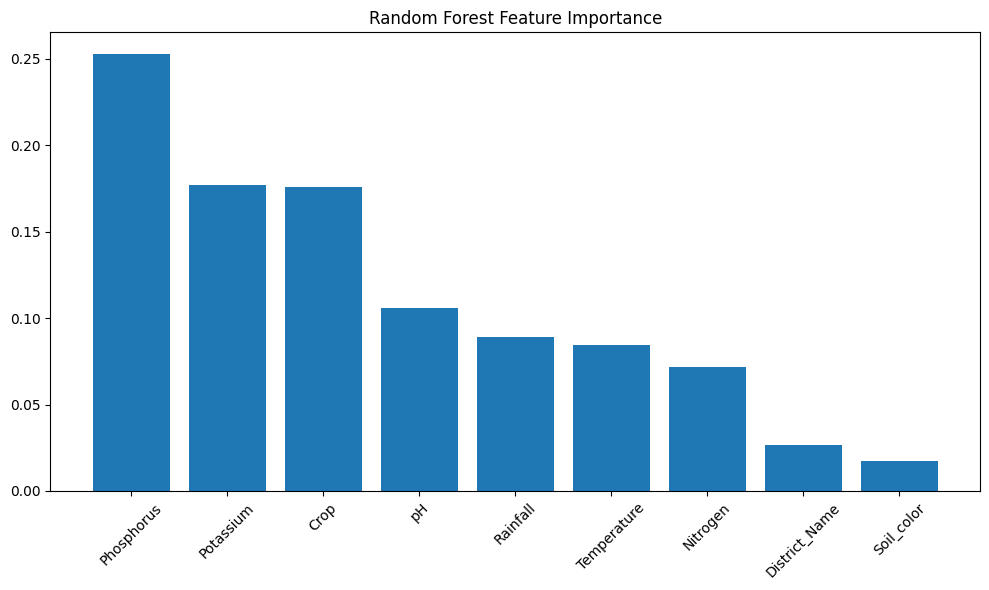


Generating SHAP explanation plots...


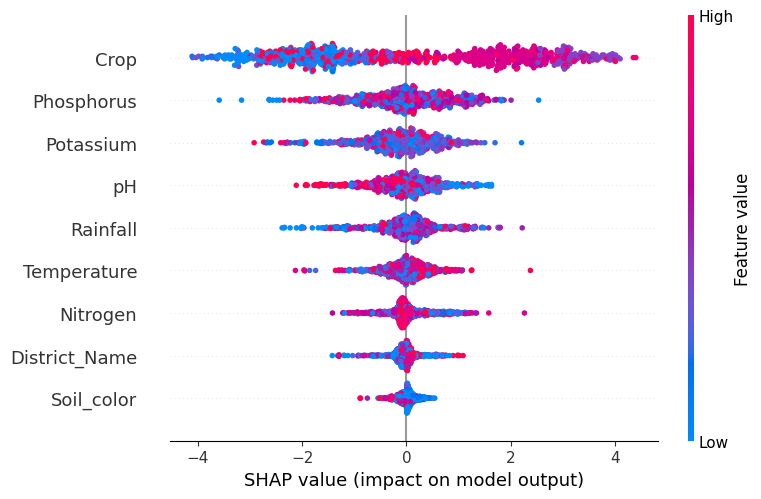

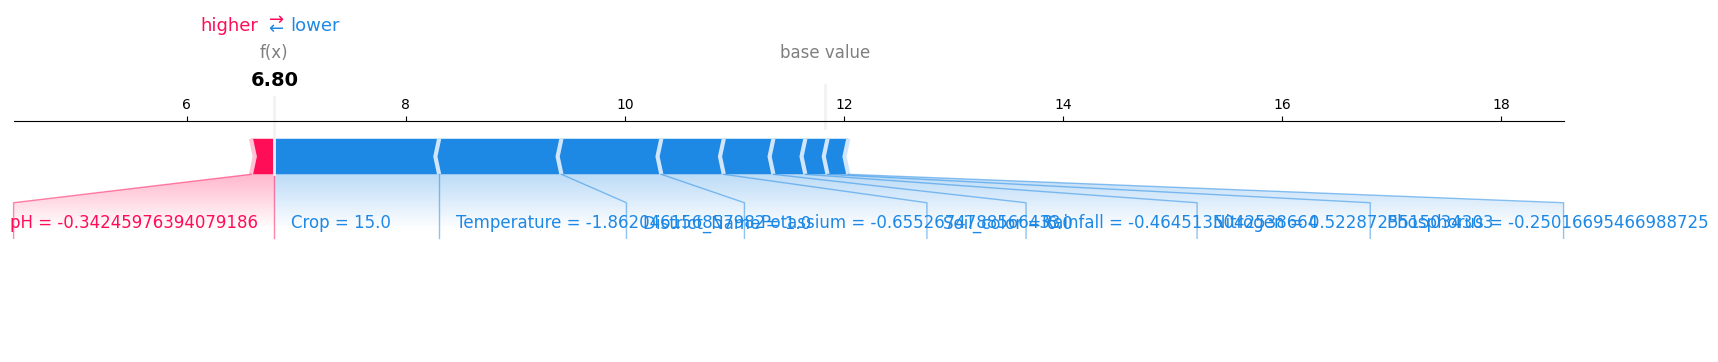

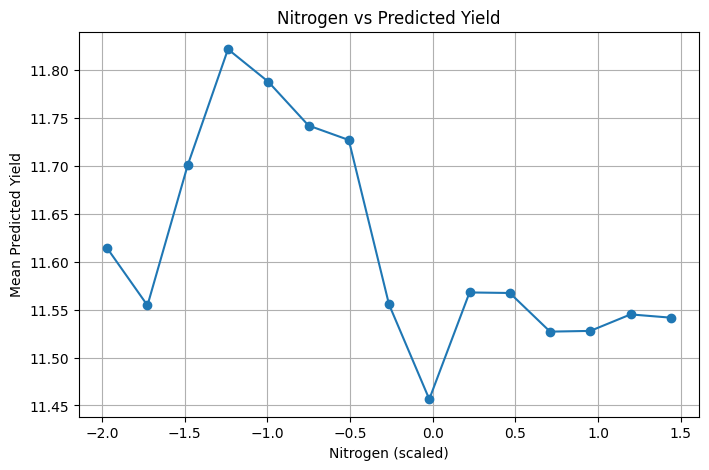

Recommended Nitrogen level (scaled): -1.2377280858036872
Max predicted mean yield: 11.8215503875969
Best combination (scaled): {'Nitrogen': np.float64(-1.2106739388947125), 'Phosphorus': np.float64(-0.3503780849803948)}
Max predicted mean yield: 11.901373200442968


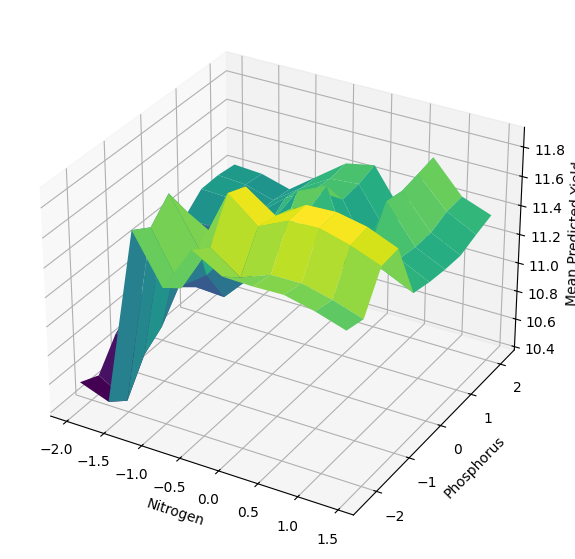

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


def process_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

    if 'Link' in df.columns:
        df = df.drop('Link', axis=1)
        print("Dropped the 'Link' column.")

    print("\nChecking for missing values...")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    df.dropna(inplace=True)
    print("Missing values handled by dropping rows.")

    df.drop_duplicates(inplace=True)
    print(f"Dropped duplicates, new shape: {df.shape}")

    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

    print("\nEncoding categorical columns...")
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        print(f"Encoded '{col}'")

    X = df.drop('Fertilizer', axis=1)
    y = df['Fertilizer']

    print(f"\nFeatures shape: {X.shape}, Target shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print("Scaled numerical features.")

    return X_train, X_test, y_train, y_test, scaler


def recommend_fertilizer(model, X_test, feature_name, min_val, max_val, steps=10):
    values = np.linspace(min_val, max_val, steps)
    preds = []
    X_mod = X_test.copy()
    for val in values:
        X_mod[feature_name] = val
        pred = model.predict(X_mod)
        preds.append(np.mean(pred))
    plt.figure(figsize=(8, 5))
    plt.plot(values, preds, marker='o')
    plt.title(f'{feature_name} vs Predicted Yield')
    plt.xlabel(feature_name + " (scaled)")
    plt.ylabel("Mean Predicted Yield")
    plt.grid(True)
    plt.show()
    max_idx = np.argmax(preds)
    print(f"Recommended {feature_name} level (scaled): {values[max_idx]}")
    print(f"Max predicted mean yield: {preds[max_idx]}")


def multi_feature_recommendation(model, X_test, feature_ranges, steps=5):
    features = list(feature_ranges.keys())
    grids = [np.linspace(v[0], v[1], steps) for v in feature_ranges.values()]
    combos = list(itertools.product(*grids))
    preds = []
    for c in combos:
        X_mod = X_test.copy()
        for i, feat in enumerate(features):
            X_mod[feat] = c[i]
        pred = model.predict(X_mod)
        preds.append(np.mean(pred))
    max_idx = np.argmax(preds)
    best_combo = combos[max_idx]
    print(f"Best combination (scaled): {dict(zip(features, best_combo))}")
    print(f"Max predicted mean yield: {preds[max_idx]}")
    if len(features) == 2:
        from mpl_toolkits.mplot3d import Axes3D
        X_val, Y_val = np.meshgrid(grids[0], grids[1])
        Z = np.array(preds).reshape(steps, steps)
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X_val, Y_val, Z, cmap='viridis')
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel('Mean Predicted Yield')
        plt.show()


if __name__ == '__main__':
    data_file = 'Crop and fertilizer dataset.csv'  # Adjust path if needed
    processed = process_data(data_file)
    if processed is not None:
        X_train, X_test, y_train, y_test, scaler = processed

        print("\nTuning Random Forest...")
        rf_grid = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid={
                'n_estimators': [50, 100],
                'max_depth': [None, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            },
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=1,
            verbose=1
        )
        rf_grid.fit(X_train, y_train)
        best_rf = rf_grid.best_estimator_
        print(f"Best RF Params: {rf_grid.best_params_}")
        print(f"Best RF RMSE (CV): {np.sqrt(-rf_grid.best_score_):.4f}")

        print("\nTuning Gradient Boosting...")
        gb_grid = GridSearchCV(
            GradientBoostingRegressor(random_state=42),
            param_grid={
                'n_estimators': [50, 100],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.7, 1]
            },
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=1,
            verbose=1
        )
        gb_grid.fit(X_train, y_train)
        best_gb = gb_grid.best_estimator_
        print(f"Best GB Params: {gb_grid.best_params_}")
        print(f"Best GB RMSE (CV): {np.sqrt(-gb_grid.best_score_):.4f}")

        print("\nTuning XGBoost...")
        xgb_grid = GridSearchCV(
            XGBRegressor(random_state=42, verbosity=0),
            param_grid={
                'n_estimators': [50, 100],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.7, 1]
            },
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=1,
            verbose=1
        )
        xgb_grid.fit(X_train, y_train)
        best_xgb = xgb_grid.best_estimator_
        print(f"Best XGB Params: {xgb_grid.best_params_}")
        print(f"Best XGB RMSE (CV): {np.sqrt(-xgb_grid.best_score_):.4f}")

        print("\nTest Set Performance:")
        models = {'Random Forest': best_rf, 'Gradient Boosting': best_gb, 'XGBoost': best_xgb}
        for name, model in models.items():
            preds = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")

        print("\n5-fold CV on tuned Random Forest...")
        cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5,
                                    scoring='neg_mean_squared_error', n_jobs=1)
        rmse_scores = np.sqrt(-cv_scores)
        print(f"CV RMSE scores: {rmse_scores}")
        print(f"Mean CV RMSE: {rmse_scores.mean():.4f}")

        importances = best_rf.feature_importances_
        feat_names = X_train.columns
        df_importances = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.bar(df_importances['Feature'], df_importances['Importance'])
        plt.xticks(rotation=45)
        plt.title('Random Forest Feature Importance')
        plt.tight_layout()
        plt.show()

        print("\nGenerating SHAP explanation plots...")
        explainer = shap.TreeExplainer(best_rf)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
        shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)

        recommend_fertilizer(best_rf, X_test, 'Nitrogen', X_test['Nitrogen'].min(), X_test['Nitrogen'].max(), steps=15)

        feature_ranges = {
            'Nitrogen': (X_test['Nitrogen'].min(), X_test['Nitrogen'].max()),
            'Phosphorus': (X_test['Phosphorus'].min(), X_test['Phosphorus'].max())
        }
        multi_feature_recommendation(best_rf, X_test, feature_ranges, steps=10)
